In [1]:
# Download of Images for model training
from tqdm import tqdm_notebook as tqdm 
import requests
import math
import os
import zipfile

if not os.path.exists("data"):
    os.mkdir("data")
    
if not os.path.exists(os.path.join("data", "PetImages")):
    url = "https://downloads.codingcoursestv.eu/037%20-%20neuronale%20netze/PetImages.zip"
    # Streaming, so we can iterate over the response.
    r = requests.get(url, stream=True)

    # Total size in bytes.
    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    
    print("Downloading...")
    with open(os.path.join("data", "PetImages.zip"), 'wb') as f:
        for data in tqdm(r.iter_content(block_size), total=math.ceil(total_size//block_size), unit='KB', unit_divisor=1024, unit_scale=True):
            f.write(data)
            
    print("Download completed")
    print("Extracting...")
    
    zip_ref = zipfile.ZipFile(os.path.join("data", "PetImages.zip"), 'r')
    zip_ref.extractall(os.path.join("data"))
    zip_ref.close()
    
    print("Done!")
else:
    print("Die Dateien existieren bereits")

Die Dateien existieren bereits


In [2]:
# Read all images to numpy array
import os
import numpy as np
from tqdm import tqdm_notebook as tqdm
from PIL import Image

def read_images(path):
  files = os.listdir(path)
  files = [file for file in files if file[-4:] == ".jpg"]

  images = []
  # uses less file due to not enough RAM
  files = files[:3000]
  for file in tqdm(files):
    try:
      img = Image.open(os.path.join(path, file))
      img = img.resize((224, 224), Image.LANCZOS)
      img = img.convert("RGB")
      img = np.asarray(img)
      images.append(img)
    except OSError:
      pass

  return images;

In [3]:
cats = read_images(os.path.join("data", "PetImages", "Cat"))
dogs = read_images(os.path.join("data", "PetImages", "Dog"))

dogs = np.asarray(dogs)
cats = np.asarray(cats)

x_train = np.concatenate([dogs, cats])

y_dogs = np.zeros(len(dogs))
y_cats = np.ones(len(cats))

y_train = np.concatenate([y_dogs, y_cats])

del dogs, cats, y_dogs, y_cats

<ipython-input-2-91c88fd56a20>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm(files):


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [4]:
# generate input data for VGG16 Model
from keras.applications.vgg16 import VGG16, preprocess_input
x_train = preprocess_input(x_train)
x_train.shape

(5999, 224, 224, 3)

In [5]:
# Train data on VGG16 model; x_train_after_vgg is then used for the mode.fit command
vgg16_model = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg16_model.trainable = False
x_train_after_vgg = vgg16_model.predict(x_train, verbose=1)
x_train_after_vgg.shape

188/188 [==============================] - 33s 123ms/step


(5999, 7, 7, 512)

In [6]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Use VGG16 data as input layer for new Model
model = Sequential()
model.add(Flatten(input_shape=(7, 7, 512)))
model.add(Dense(1024, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Adam(lr=0.0001), loss="binary_crossentropy", metrics=["acc"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 16)                16400     
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 25,707,553
Trainable params: 25,707,553
Non-trainable params: 0
_________________________________________________________________


In [9]:
from sklearn.utils import shuffle

# sheffel input data to get better results
x_train_after_vgg, y_train = shuffle(x_train_after_vgg, y_train)

In [10]:
# validation split uses 20% of data to make prediction on the trained weights. Will do better results. 
model.fit(x_train_after_vgg, y_train, epochs=50, batch_size=64, validation_split=0.2, shuffle=True)

Epoch 1/50
75/75 [==============================] - 2s 18ms/step - loss: 0.3368 - acc: 0.9031 - val_loss: 0.0977 - val_acc: 0.9783
Epoch 2/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0746 - acc: 0.9815 - val_loss: 0.1517 - val_acc: 0.9775
Epoch 3/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0466 - acc: 0.9887 - val_loss: 0.1110 - val_acc: 0.9742
Epoch 4/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0424 - acc: 0.9923 - val_loss: 0.0739 - val_acc: 0.9800
Epoch 5/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0279 - acc: 0.9944 - val_loss: 0.1626 - val_acc: 0.9675
Epoch 6/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0250 - acc: 0.9950 - val_loss: 0.2743 - val_acc: 0.9750
Epoch 7/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0366 - acc: 0.9937 - val_loss: 0.1656 - val_acc: 0.9667
Epoch 8/50
75/75 [==============================] - 1s 16ms/step - loss: 0.0451 - a

In [12]:
model.evaluate(x_train_after_vgg, y_train)

188/188 [==============================] - 1s 5ms/step - loss: 0.0303 - acc: 0.9962


[0.030298611149191856, 0.9961660504341125]

**Make Prediction on images**

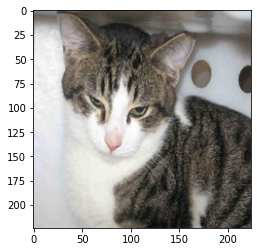

1/1 [==============================] - 0s 22ms/step
Cat: True; 100%


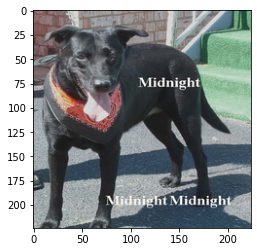

1/1 [==============================] - 0s 28ms/step
Cat: False; 0%


In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

def is_it_a_cat(path):
  res = False
  img = Image.open(path)

  img = np.asarray(img.resize((224, 224), resample=Image.LANCZOS))
  plt.imshow(img)
  plt.show()

  img = preprocess_input(img)
  img = img.reshape(1, 224, 224, 3)

  # generate data after vgg to use it as input to our trained model
  x_after_vgg = vgg16_model.predict(img, verbose=1)

  pred = model.predict(x_after_vgg)
  if (pred[0][0]) >= 0.95:
    res = True
  print("Cat: " + str(res) + "; " + str(round(pred[0][0] * 100)) + "%")
  return res;

res_cat = is_it_a_cat("data/PetImages/Cat/10371.jpg")
res_dog = is_it_a_cat("data/PetImages/Dog/10371.jpg")

Mounted at /content/drive


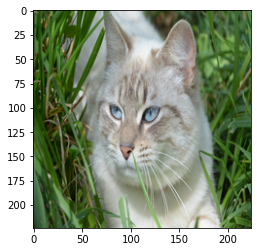

1/1 [==============================] - 0s 22ms/step
Cat: True; 100%


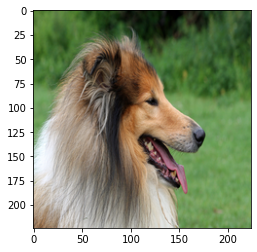

1/1 [==============================] - 0s 20ms/step
Cat: False; 0%


In [48]:
from google.colab import drive 
drive.mount("/content/drive", force_remount=True)
cat = is_it_a_cat("/content/drive/MyDrive/NeuralNetwork/cat.jpg");
dog = is_it_a_cat("/content/drive/MyDrive/NeuralNetwork/dog.jpg");